In [1]:
from IPython.display import clear_output
import pyrealsense2 as rs
import numpy as np
import cv2
from IPython.display import Image
from PIL import Image as PILImage
import io
import time
import sys
from unitree_sdk2py.core.channel import ChannelSubscriber, ChannelFactoryInitialize
from unitree_sdk2py.idl.default import unitree_go_msg_dds__SportModeState_
from unitree_sdk2py.idl.unitree_go.msg.dds_ import SportModeState_
from unitree_sdk2py.go2.video.video_client import VideoClient
from unitree_sdk2py.go2.sport.sport_client import (
    SportClient,
    PathPoint,
    SPORT_PATH_POINT_SIZE,
)
from unitree_sdk2py.go2.obstacles_avoid.obstacles_avoid_client import ObstaclesAvoidClient
import math
from dataclasses import dataclass
import matplotlib.pyplot as plt

%matplotlib inline

## get camera feed from both the cameras (default camera and add on) side by side

In [2]:
# setup for default camera
ChannelFactoryInitialize(0,"eth0")
client = VideoClient()
client.SetTimeout(1.0)
client.Init()


In [3]:
# setup for add on camera
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.color, 1920, 1080, rs.format.bgr8, 30)
Object_colors = list(np.random.rand(80,3)*255)
# Start pipeline
pipeline.start(config)

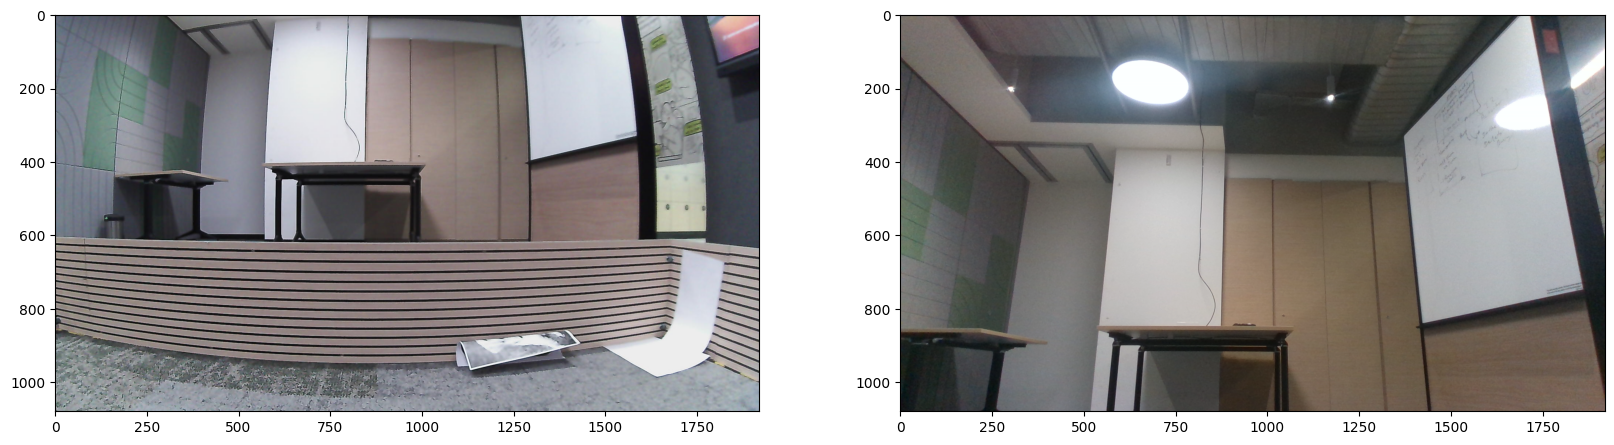

In [ ]:
while True:
    # feed from default camera
    code,data = client.GetImageSample()
    img_1 = np.frombuffer(bytes(data), dtype=np.uint8)
    image_1 = cv2.imdecode(img_1, cv2.IMREAD_COLOR)
    image_1_rgb = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)

     # Wait for a frame from the RealSense camera
    frames = pipeline.wait_for_frames()
    color_frame = frames.get_color_frame()
    image_2 = np.asanyarray(color_frame.get_data())
    image_2_rgb = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
    
    clear_output(wait=True)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,12))
    # fig.
    ax[0].imshow(image_1_rgb)
    ax[1].imshow(image_2_rgb)
    plt.show()
    time.sleep(0.1)
    

In [5]:
import pyrealsense2 as rs
import numpy as np
import cv2

# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()

# Get device product line for setting a supporting resolution
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))

found_rgb = False
for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        found_rgb = True
        break
if not found_rgb:
    print("The demo requires Depth camera with Color sensor")
    exit(0)

config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Start streaming
pipeline.start(config)

try:
    while True:

        # Wait for a coherent pair of frames: depth and color
        frames = pipeline.wait_for_frames()
        depth_frame = frames.get_depth_frame()
        color_frame = frames.get_color_frame()
        if not depth_frame or not color_frame:
            continue

        # Convert images to numpy arrays
        depth_image = np.asanyarray(depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())

        # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)

        depth_colormap_dim = depth_colormap.shape
        color_colormap_dim = color_image.shape

        # If depth and color resolutions are different, resize color image to match depth image for display
        if depth_colormap_dim != color_colormap_dim:
            resized_color_image = cv2.resize(color_image, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
            images = np.hstack((resized_color_image, depth_colormap))
        else:
            images = np.hstack((color_image, depth_colormap))

        # Show images
        cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
        cv2.imshow('RealSense', images)
        cv2.waitKey(1)

finally:

    # Stop streaming
    pipeline.stop()

KeyboardInterrupt: 